
## Bagging vs. Random Forest: Impact of Tree Decorrelation On Prediction Accuracy

#### Nassima Bettir
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

Accurately predicting the Rate of Penetration (ROP) in drilling operations is essential for optimizing drilling efficiency and reducing costs. Traditional single decision-tree approaches often suffer from high variance and overreliance on a few dominant features. This project addresses the question: How does forcing additional randomness (decorrelation) in tree ensembles (by limiting the number of features at each split) impact predictive performance for ROP?

We began by thoroughly preprocessing and exploring the drilling dataset, capping unrealistic Flow Rate and Rotary Speed values, and examining both univariate and bivariate distributions to identify anomalies and correlations. Next, we implemented and compared Bagging and Random Forest methods, systematically varying the number of features (max_features) at each split to measure Out-of-Bag (OOB) MSE, tree–tree correlation, and feature importance. This methodology revealed how restricting the feature pool in Random Forest effectively decorrelates the trees, providing a more robust and diverse ensemble than pure Bagging.

Our results showed that limiting the number of features at each split can significantly improve OOB performance by reducing correlation among the trees, yet it remains essential to avoid overly small feature subsets that risk underfitting. We observed that a moderate max_features value often strikes the ideal balance, giving secondary features room to contribute while still leveraging strong predictors. Additionally, the shifting patterns in feature importance demonstrated how sub-sampling can mitigate the dominance of a single strong variable, ultimately yielding a more balanced and in many cases, more accurate model for predicting Rate of Penetration.

### Packages

In [4]:
import math                                                   # Access to the mathematical functions
import numpy as np                                            # Arrays 
import scipy.stats as stats                                   # Statistical methods
import pandas as pd                                           # DataFrames
import matplotlib.pyplot as plt                               # Plotting
import seaborn as sns                                         # Matrix scatter plots
from sklearn.ensemble import RandomForestRegressor            # Random Forest
from sklearn import metrics                                   # Measures to check our model performance
from sklearn.metrics import mean_squared_error
import warnings                                               # Ignore warnings
warnings.filterwarnings('ignore')
seed = 13                                                     # Workflow repeatability

### Functions

In [6]:
def average_tree_correlation(rf_model, x_data):
    
    all_tree_preds = np.array([tree.predict(x_data) for tree in rf_model.estimators_]).T         # Predictions from each individual tree
    corr_matrix = np.corrcoef(all_tree_preds, rowvar=False)                                      # Correlation matrix among tree predictions
    num_trees = corr_matrix.shape[0]                                                             # Average off-diagonal correlation
    upper_triangle = np.triu_indices(num_trees, k=1)                             # To sum all upper or lower-tri correlations & divide by number of pairs
    avg_corr = corr_matrix[upper_triangle].mean()
    
    return avg_corr

### Loading Data

The following workflow applies the .xlsx file 'Well_58-32_dataset.xlsx', an excerpt of a real dataset containing real-world diagnostic drilling data from Well 58-32, collected near Milford, Utah during Phase 2B of the FORGE Project. The dataset, recorded at 1Hz and downscaled to ~1 ft intervals, includes processed Pason log files for evaluating geothermal reservoir conditions. The complete dataset is available [here](https://gdr.openei.org/submissions/1113).

&nbsp; Our excerpt contain the following columns (features):

1. **Depth**: Well depth in feet [ft]

2. **ROP**: Rate of penetration in feet per hour [ft/h]

3. **WOB**: Weight on bit in kilopounds [klb]

4. **Surface Torque**: Rotational force applied at the surface that is transmitted down the drill string to the drill bit in pound per square inch [psi]

5. **Rotary Speed**: Surface induced rotation speed in revolutions per minute [rev/min]

6. **FLow Rate**: Mud flow rate going in the drillstring in gallons per minute [gal/min]

7. **Hookload**: Weight or load applied on the drill string at the hook of the drilling rig in kilopounds [klb]




In [8]:
df = pd.read_excel(r"C:\Users\nassi\OneDrive - The University of Texas at Austin\Subsurface ML\ML project\Well_58-32_dataset.xlsx")
df.columns = df.columns.str.strip()  # removing whitespace from column names

### Workflow Overview

Below is a concise overview of the workflow used in this project. My goal is to illustrate the effect of tree decorrelation on predictive accuracy by camparing Bagging and Random forest.

**1. Data Preprocessing**

I began by loading the drilling dataset, ensuring only valid observations remained (for instance, removing rows where WOB ≤ 0), and verifying the dataset had no missing values. Next, I performed univariate and bivariate analyses to uncover basic distribution patterns and relationships among my feautures. 

**2. Tree Decorrelation Impact: Bagging vs. Random Forest**

I compared Bagging and Random Forest by varying max_features (number of features at each split)  from the total number of features (pure Bagging) down to 1 (fully decorrelated). At each setting, I recorded Out-of-Bag (OOB) MSE as an accuracy measure, computed average tree–tree correlation to gauge decorrelation among individual trees, and examined feature importances to observe how frequently each feature was used in splits under different max_features values.

**3. Conclusion**

I examined how varying max_features influenced overall model performance, correlation among trees, and the distribution of feature usage. Then, I provided a broader interpretation of how each approach (Bagging or more highly randomized forests) can align with specific data conditions and modeling objectives.

### 1. Data Preprocessing 

In this step, we review the dataset by computing descriptive statistics and visualizing both univariate and bivariate distributions. These actions help us detect correlations among variables, as well as spot any outliers, or other issues requiring attention before we proceed to utilize these features in further modeling steps.

#### 1.1. Visualizing the Dataframe

It is awlays useful to check our data

In [12]:
df.head(n=13)                                                 

,Depth,WOB,Surface Torque,Rotary Speed,Flow Rate,Hookload,ROP
0,85.18,0.00,8.93,151.09,1109.58,31.77,56.80
1,86.18,0.00,8.93,151.09,1108.36,31.01,61.14
2,87.23,0.00,9.01,61.54,1102.87,31.01,18.58
3,88.26,0.00,8.97,60.23,1101.04,31.16,38.29
4,89.36,0.00,8.97,61.75,1102.46,31.54,394.38
5,90.39,0.00,8.97,61.99,1101.85,30.24,413.16
6,91.39,0.76,8.97,62.07,1102.06,29.33,450.72
7,92.39,0.00,9.01,61.95,1102.26,31.01,600.96
8,93.49,0.00,8.97,61.42,1099.21,30.93,399.50
9,94.59,0.00,9.01,59.57,1102.87,30.78,563.40


####
- We can see from the table above that the **count** is the same for all feautres, meaning there are no missing values in our dataest. 

If we want to be really sure, we can try this: 
####

In [14]:
df.isna().sum()

Depth             0
WOB               0
Surface Torque    0
Rotary Speed      0
Flow Rate         0
Hookload          0
ROP               0
dtype: int64

We can see that the **count** matches **df.shape[0]** (number of rows), then yes, our columns are clean.

#### 1.2. Summary Statistics for Tabular Data

A summary statistics table provides a descriptive overview of each feature’s distribution.

In [17]:
df.describe().transpose()                         # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Depth,7311.0,3835.043935,2147.503980,85.18,1970.395,3851.85,5691.585,7536.25
WOB,7311.0,23.116699,9.119495,0.00,18.310,23.83,29.680,47.05
Surface Torque,7311.0,130.983649,48.706651,0.00,117.000,140.31,157.280,273.71
Rotary Speed,7311.0,54.947292,25.947654,0.00,38.090,50.38,75.965,271.58
Flow Rate,7311.0,716.254127,141.784179,0.00,620.260,700.21,824.610,3317.51
Hookload,7311.0,81.285593,26.503832,27.27,54.720,80.14,105.630,148.93
ROP,7311.0,42.010324,75.921118,0.00,11.400,17.99,44.295,2977.91


- We can see a notable gap between the 75th percentile and the maximum values in ROP, Flow Rate, and Rotary Speed which suggests these features may have a pronounced long tail distribution. Since these extreme values occur infrequently and thus have sparse coverage they may be treated as outliers. We can confirm through visual inspection using univariate and bivariate distributions.
- The minimum value of WOB is 0, but since we are interested in predicting ROP during active drilling, we will retain only those records where WOB > 0 to ensure the data truly reflects drilling conditions.

#### 1.3. Univariate Distributions


The following code block is modified from Professor Michael Pyrcz (@GeostatsGuy), MachineLearning_feature_ranking.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/MachineLearningDemos/blob/main/MachineLearning_feature_ranking.ipynb).

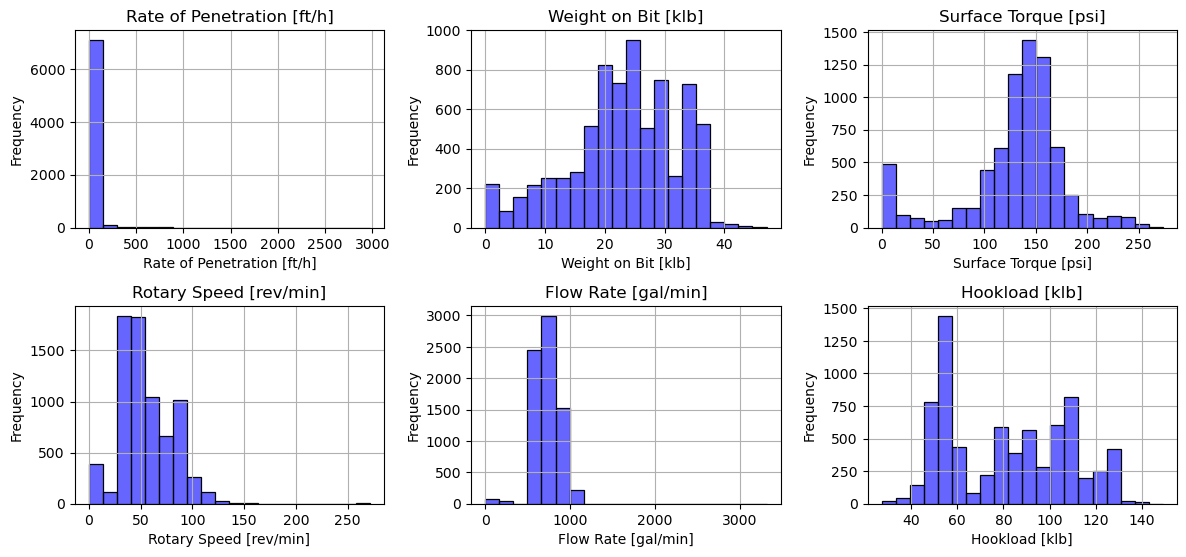

In [21]:
feature_labels = {
    'ROP': 'Rate of Penetration [ft/h]',
    'WOB': 'Weight on Bit [klb]',
    'Surface Torque': 'Surface Torque [psi]',
    'Rotary Speed': 'Rotary Speed [rev/min]',
    'Flow Rate': 'Flow Rate [gal/min]',
    'Hookload': 'Hookload [klb]'
}
features = ['ROP','WOB','Surface Torque','Rotary Speed','Flow Rate','Hookload']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, start=1):
    plt.subplot(3, 3, i)  
    sns.histplot(
        data=df,
        x=feature,
        bins=20,           
        kde=False,         
        color='blue',
        edgecolor='black',
        alpha=0.6
    )
    display_label = feature_labels.get(feature, feature) 
    plt.title(display_label)
    plt.xlabel(display_label)
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

#### 1.4. Bivariate Distributions

Matrix scatter plots help us visualize  the bivariate relationships between our  variables.

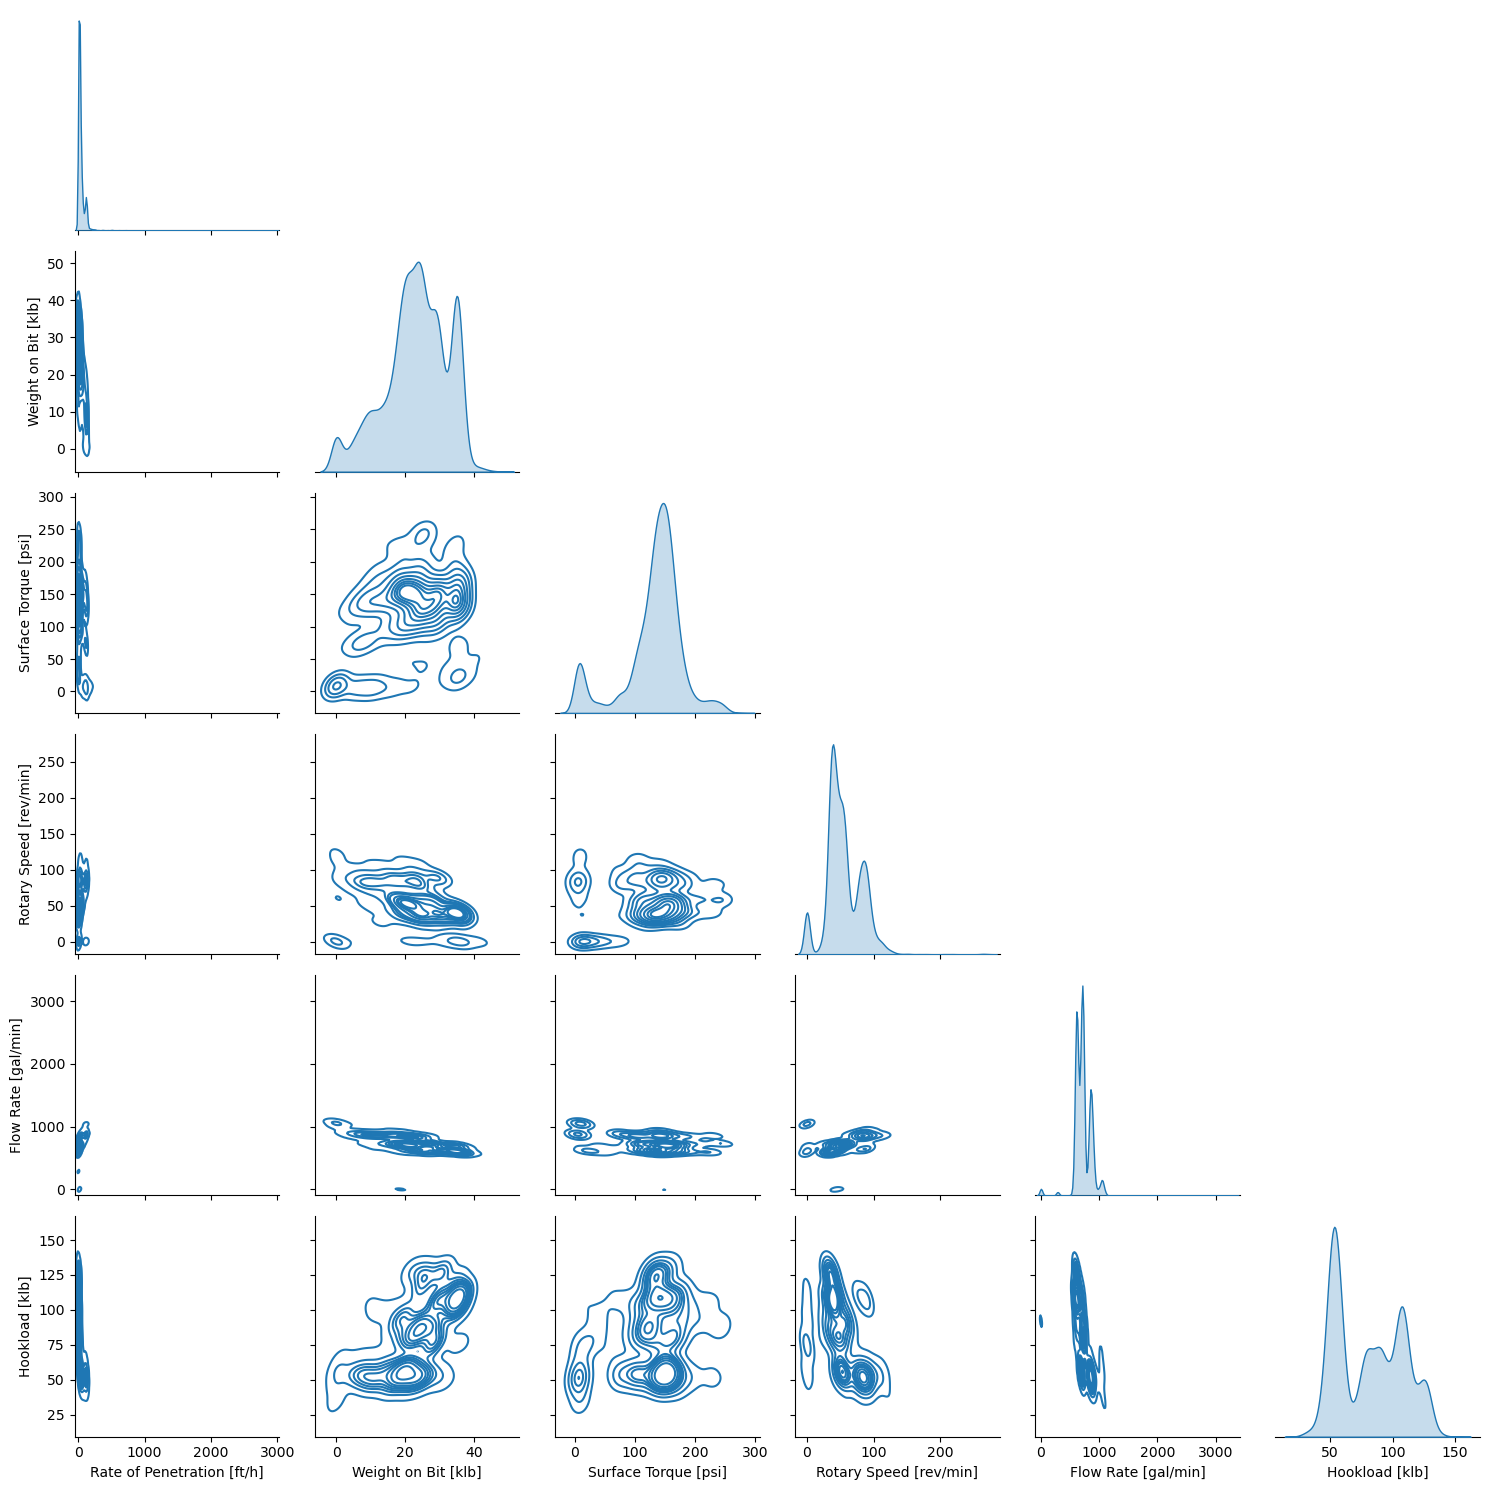

In [23]:
g = sns.pairplot(
    df[features], 
    diag_kind='kde',    
    kind='kde',        
    corner=True        
)

for ax, col_name in zip(g.axes[-1, :], g.x_vars):
    if ax is not None:  
        ax.set_xlabel(feature_labels.get(col_name, col_name))

for ax, row_name in zip(g.axes[:, 0], g.y_vars):
    if ax is not None:
        ax.set_ylabel(feature_labels.get(row_name, row_name))

plt.tight_layout()
plt.show()

Observations:


- Flow Rate exhibits a narrow right tailed distribution, this could be tied to sensor or data entry errors. Hydraulic pumps don't deliver flows exceeding 2000 gpm (note that in our dataset the maximum value is 3317.51 gpm). Hence, I will remove observations above 1500 gpm to make my dataset more realistic.
- Likewise, for Rotary Speed (RPM), we see a thin right tailed distribution , likely caused by incorrect sensor readings. I will remove observations above 150 rev/min.
- ROP exhibits a markedly skewed distribution, with a small number of unusually high values pushing the mean far above the median. This may be due to inaccurate calibration or measurement. We can try to delete these records.



#### 1.5. Cleaning the Dataset


In [26]:
df = df[
    (df["WOB"] > 0) &
    (df["Flow Rate"] < 1500) &
    (df["Rotary Speed"] < 150) &
    (df["ROP"] < 150)
]


To check our work, we need to re visualize the dataset:

In [28]:
df.describe().transpose()                                     # re- calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Depth,7032.0,3972.933383,2068.473667,286.71,2177.1850,3989.040,5760.2825,7536.25
WOB,7032.0,23.906620,8.281600,0.40,18.9900,24.155,29.9050,47.05
Surface Torque,7032.0,135.616044,43.344264,0.00,121.0100,141.570,157.9600,273.71
Rotary Speed,7032.0,54.722642,23.886852,0.00,38.2400,50.230,74.7975,146.03
Flow Rate,7032.0,704.586675,124.470956,0.00,619.1700,698.170,740.5300,1417.55
Hookload,7032.0,82.475082,26.190747,39.42,55.1275,82.570,106.0800,148.93
ROP,7032.0,32.779167,33.669895,0.00,11.1900,17.260,40.3900,149.76


The following code block is modified from Professor Michael Pyrcz (@GeostatsGuy), MachineLearning_feature_ranking.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/MachineLearningDemos/blob/main/MachineLearning_feature_ranking.ipynb).

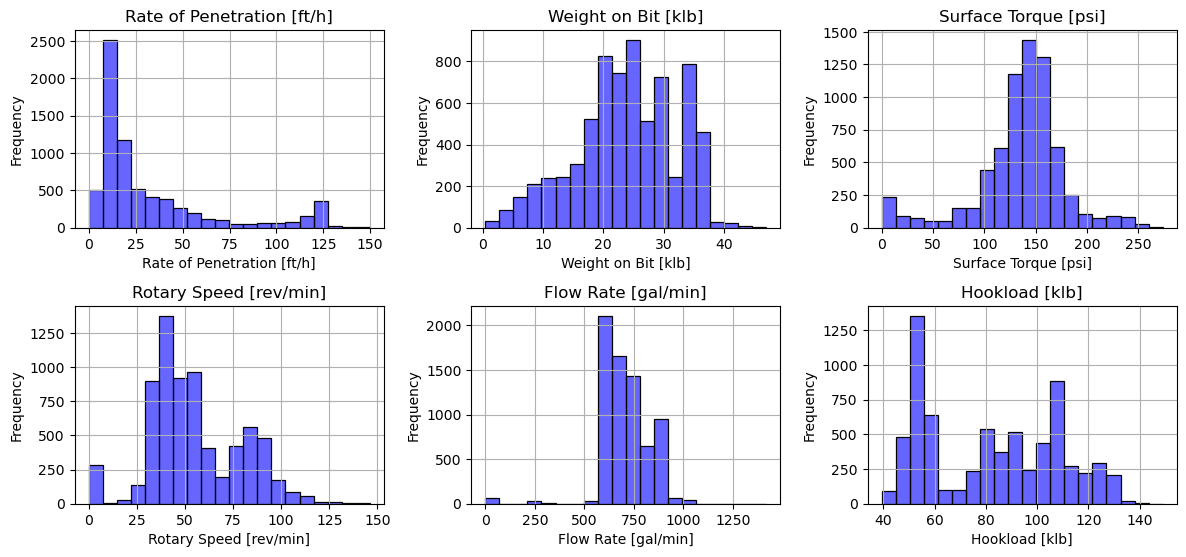

In [30]:
# Univariate Distributions
feature_labels = {
    'ROP': 'Rate of Penetration [ft/h]',
    'WOB': 'Weight on Bit [klb]',
    'Surface Torque': 'Surface Torque [psi]',
    'Rotary Speed': 'Rotary Speed [rev/min]',
    'Flow Rate': 'Flow Rate [gal/min]',
    'Hookload': 'Hookload [klb]'
}
features = ['ROP','WOB','Surface Torque','Rotary Speed','Flow Rate','Hookload']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, start=1):
    plt.subplot(3, 3, i)  
    sns.histplot(
        data=df,
        x=feature,
        bins=20,           
        kde=False,         
        color='blue',
        edgecolor='black',
        alpha=0.6
    )
    display_label = feature_labels.get(feature, feature) 
    plt.title(display_label)
    plt.xlabel(display_label)
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

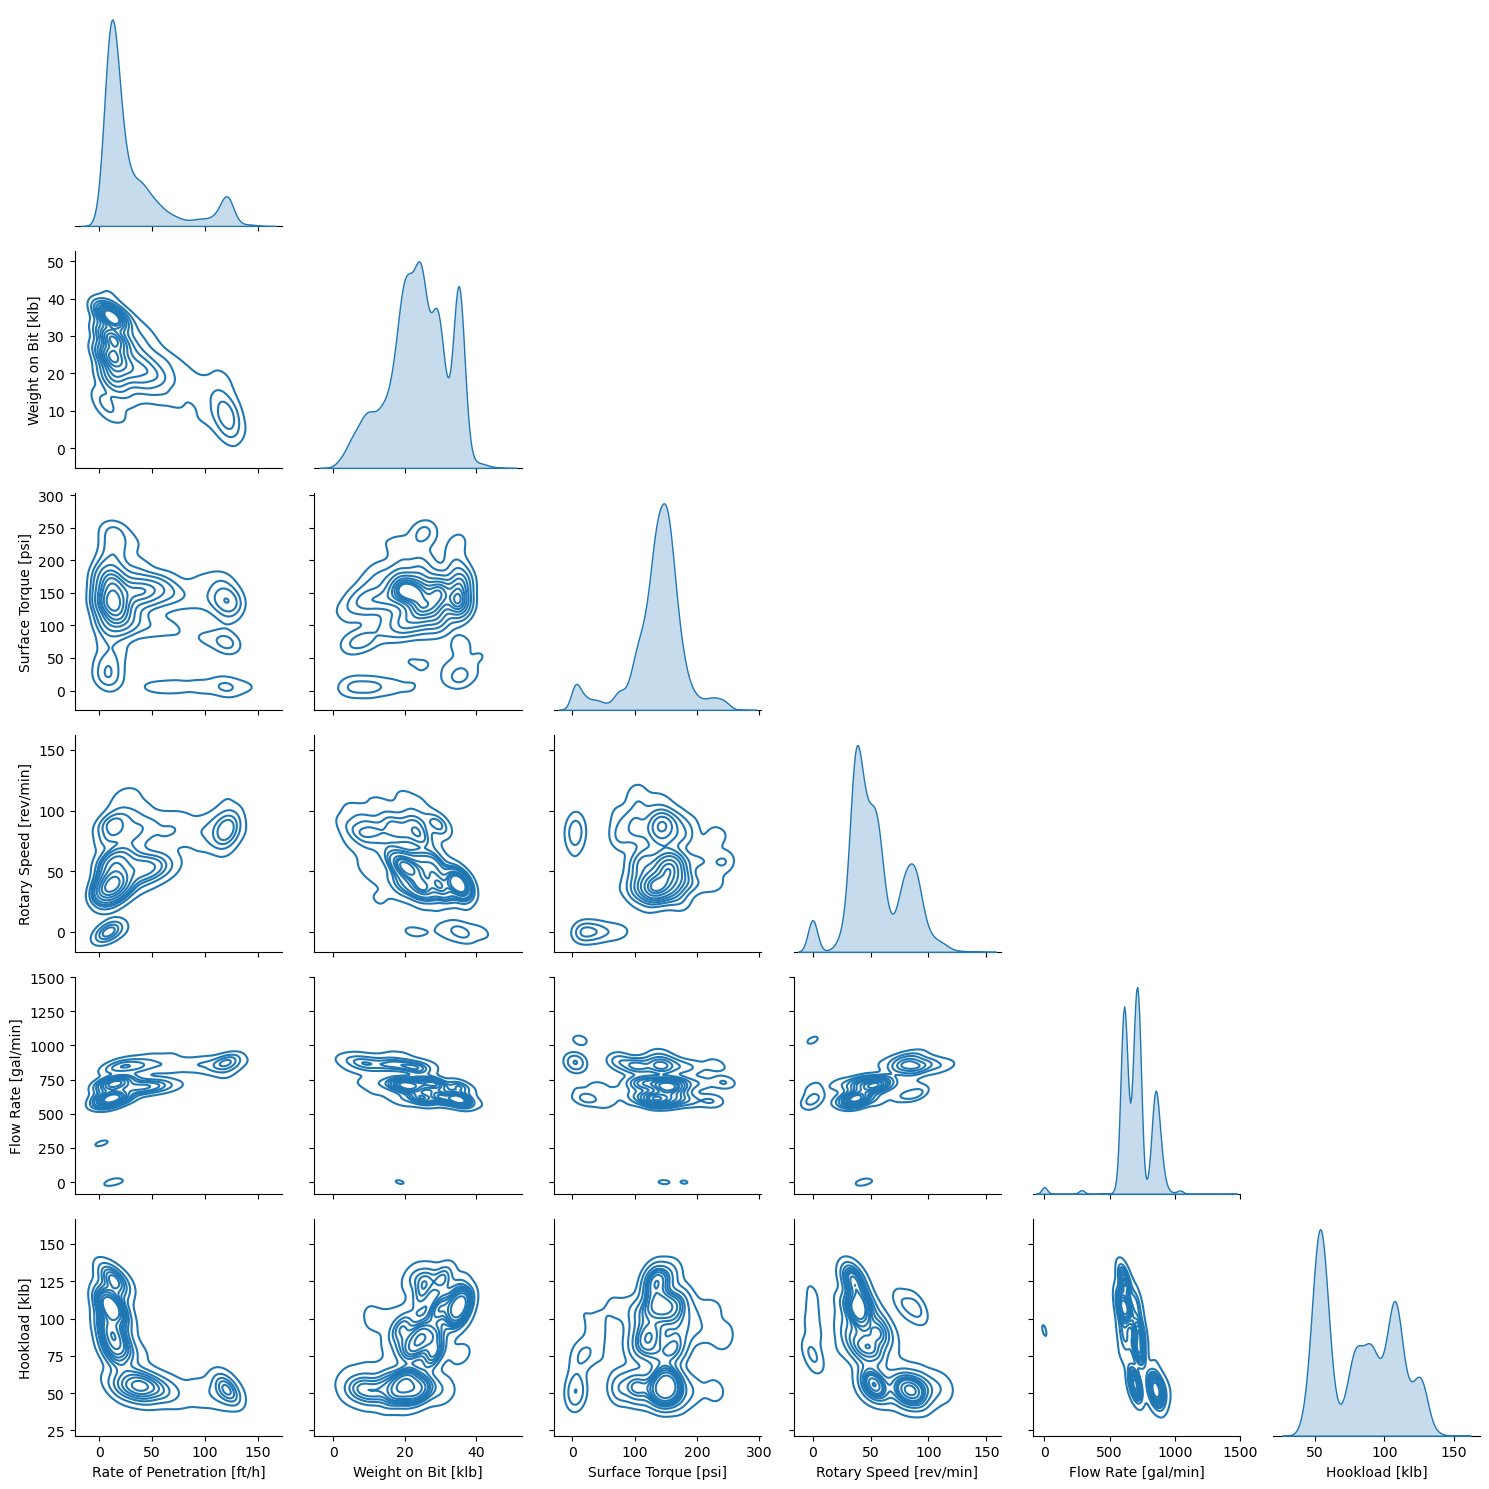

In [31]:
# Bivariate Distributions
g = sns.pairplot(
    df[features], 
    diag_kind='kde',    
    kind='kde',        
    corner=True        
)

for ax, col_name in zip(g.axes[-1, :], g.x_vars):
    if ax is not None:  
        ax.set_xlabel(feature_labels.get(col_name, col_name))

for ax, row_name in zip(g.axes[:, 0], g.y_vars):
    if ax is not None:
        ax.set_ylabel(feature_labels.get(row_name, row_name))

plt.tight_layout()
plt.show()

- Our dataset looks much better now. The distribtions are no longer heavily skewed and the outliers have been taken care of. 

### 2. Tree Decorrelation Impact: Bagging vs. Random Forest
**Bagging**: 

   
Bootstrap aggregating (Bagging) is an ensemble method where multiple decision trees are trained on different bootstrap samples of the data. A bootstrap sample is created by drawing observations from the original dataset with replacement, typically the same size as the original dataset. Each tree is trained independently, and their outputs are then averaged (for regression) or voted on (for classification). This approach helps reduce variance and often improves predictive performance compared to a single decision tree $^{[1]}$.

**Random Forest**: 

Random Forest extends Bagging by adding an additional layer of randomness. At each tree split, only a sub-sample of features (determined by max_features) is considered, rather than all features. This random subspace approach decorrelates the trees, since they can’t all rely on the same strong predictors at each split. The ensemble of these more diverse trees often yields better performance and reduces overfitting compared to standard Bagging $^{[1]}$.


To demonstarte the effect of tree decorrelation on prediction accuracy: we systematically varied max_features from the full set of predictors (pure Bagging) down to one (maximal decorrelation), then analyzed how Out-of-Bag (OOB) MSE, tree–tree correlation, and feature importance changed under each setting. This allowed us to visualize both the accuracy gains and how feature usage diversifies as fewer features are made available to each tree split.

#### 2.1. Out-of-Bag Mean Squared Error vs. Number of Features at each Split 

Out of Bag Mean Squared Error ($MSE_{OOB}$): 

During training, each tree is fitted on a bootstrap sample, which includes (in expectation) about two-thirds of the original dataset. Consequently, the remaining one-third of the data is left out of training for that tree (these are referred to as out-of-bag observations). For each data point, there are multiple OOB predictions available from the subset of trees that did not train on it. By aggregating these predictions (using the mean for regression or the mode for classification) we compute a single out-of-bag prediction for each sample $^{[1]}$.

Comparing these aggregated OOB predictions against the true targets across the dataset yields an unbiased estimate of model error known as the Out-of-Bag Mean Squared Error (OOB MSE), typically expressed as $^{[1]}$:

$MSE_{OOB} = \sum_{\alpha = 1}^{\frac{B}{3}} \left[ y^{*}_{\alpha} - y_{\alpha} \right]^2$

where: 

- $y_{\alpha}$ : response feature observations
- $y^{*}_{\alpha}$ : single out of bag predictions.

This approach eliminates the need for training and testing split, offering an efficient and reliable means of evaluating model performance $^{[1]}$. 

>*$^{[1]}$ Pyrcz, M.J., 2024, Applied Machine Learning in Python: A Hands-on Guide with Code [e-book](doi:10.5281/zenodo.15169138). Zenodo. doi:10.5281/zenodo.15169138*

Here, we illustrate how the number of features (m) considered at each split affects the ensemble’s accuracy by plotting the Out-of-Bag (OOB) MSE. In particular, when m = 5, we mimic Bagging, since all features are available at each split. 

Conversely, when m = 1, each split uses a single (randomly chosen) feature, leading to maximally decorrelated trees. By varying m across this range, we can see how limiting the feature set often influences and potentially improves predictive performance.

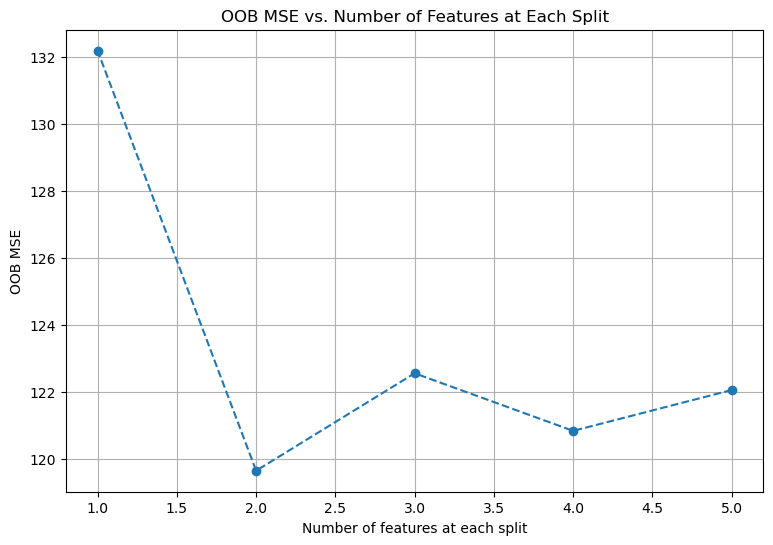

In [35]:
response = 'ROP'  
x = df.copy(deep=True).drop(['Depth', response], axis='columns') # specify our predictor features
Y = df[response] # specify our response feature

m = x.shape[1] 
oob_errors = []
mf_values = range(m, 0, -1)

for mf in mf_values:
    rf = RandomForestRegressor(n_estimators=100,
                               max_features=mf,
                               oob_score=True,
                               random_state=42)
    rf.fit(x, Y)
    # OOB MSE modified from Scikit-learn, https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
    oob_preds = rf.oob_prediction_ 
    mse = mean_squared_error(Y, oob_preds)
    oob_errors.append(mse)

plt.figure(figsize=(9,6))

plt.plot(mf_values, oob_errors, marker='o', linestyle='--')
plt.title("OOB MSE vs. Number of Features at Each Split")
plt.xlabel("Number of features at each split")
plt.ylabel("OOB MSE")
plt.grid(True)
plt.show()

From the plot above, we can see that  m = 2 yields the lowest OOB MSE (around 120) implying that allowing two features per split delivers the best balance between tree diversity and each split’s predictive strength. At m = 1, the model likely becomes too limited in each split choice, leading to a relatively high MSE. Once we reach m = 3, 4, or 5, the error fluctuates slightly, but it doesn’t go below what we see at m = 2. 
- Too few features (m = 1) makes each tree too “weak” or too random.
- Using all features (m = 5) is more like standard Bagging, which can overemphasize strong predictors and reduce the ensemble’s overall benefit from diversity.
- m = 2 seems to be the sweet spot, providing enough feature variety to decorrelate the trees and enough predictive information per split to avoid underfitting. Consequently, the ensemble achieves a lower OOB MSE compared to both fully randomized (1 feature) and fully bagged (all features) scenarios.



#### 2.2. Average Tree-Tree Correlation vs. Number of Features at each Split 
Zhang & Wang (2009) define tree similarity as the average Pearson correlation between the predictions of one tree and all other trees in the Random Forest model. For each tree $T$, the average correlation $𝜌_{T}$ with all other trees is calculated and the tree with highest $𝜌_{T}$ is considered the most similar to the ensemble $^{[2]}$. 

I applied this similarity concept to calculate the average correlation among all trees in the ensemble (see Functions block), following the workflow outlined below: 

- m = number of trees in the Random Forest  
- n = number of samples in the dataset  
- $\mathbf{P}_j = \left[ T_j(x_1),\ T_j(x_2),\ \dots,\ T_j(x_n) \right]^\top$ = prediction vector of tree $j$, for $j = 1, \dots, m$  

**Step 1:**  we construct the prediction Matrix:
$$
\mathbf{P} = 
\begin{bmatrix}
T_1(x_1) & T_2(x_1) & \dots & T_m(x_1) \\
T_1(x_2) & T_2(x_2) & \dots & T_m(x_2) \\
\vdots & \vdots & \ddots & \vdots \\
T_1(x_n) & T_2(x_n) & \dots & T_m(x_n)
\end{bmatrix}
$$

**Step 2 :** we compute the pairwise correlation matrix 

$$ 
C_{i,j} = \mathrm{corr}(\mathbf{P}_i,\ \mathbf{P}_j)
\quad \forall\ i,j \in \{1, \dots, m\}
$$

**Step 3 :** we extract only the Off-Diagonal Upper Triangle Indices, this is because the diagonal is the correlation of each tree with itself, which is always 1

**Step 4:** we calculate the overall Average Tree Correlation




>*$^{[2]}$ Zhang, H., & Wang, M. (2009). Search for the smallest random forest. Statistics and Its Interface, 2(3), 381. https://doi.org/10.4310/SII.2009.V2.N3.A11*
 

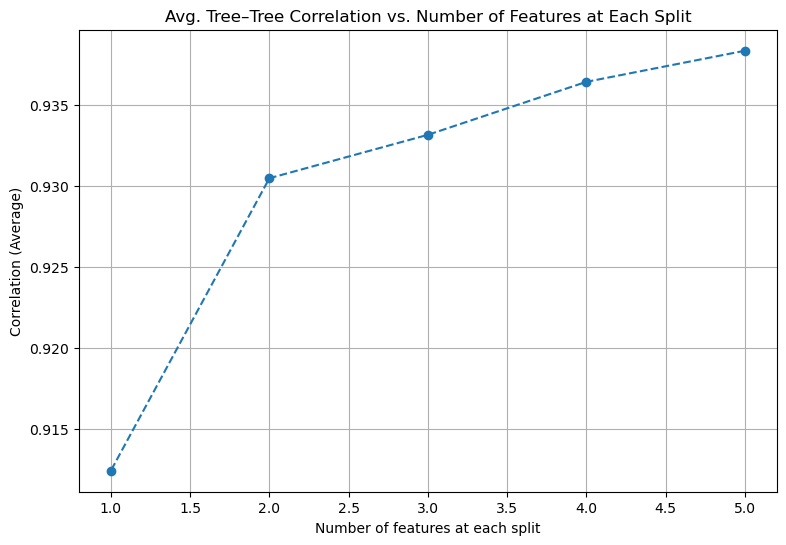

In [39]:
import warnings
warnings.filterwarnings('ignore')

m = x.shape[1] # total number of features
corr_results = []
mf_values = range(m, 0, -1)   

for mf in mf_values:
    rf = RandomForestRegressor(n_estimators=100,
                               max_features=mf,
                               oob_score=True,
                               random_state=42)
    rf.fit(x, Y)
    
    avg_corr = average_tree_correlation(rf, x) # average tree–tree correlation
    corr_results.append(avg_corr)

plt.figure(figsize= (9,6))
plt.plot(mf_values, corr_results, marker='o', linestyle='--')
plt.title("Avg. Tree–Tree Correlation vs. Number of Features at Each Split")
plt.xlabel("Number of features at each split")
plt.ylabel("Correlation (Average)")
plt.grid(True)
plt.show()
    

- When max_features = 5, all features are available at every split, which effectively replicates Bagging, the only randomness comes from bootstrapping the samples. Since each tree can repeatedly split on the same strong predictors, the trees end up more similar, resulting in higher correlation (up to around 0.94). 
- When 1 <= max_features < m, we introduce the additional randomness of Random Forest, where at each split only a subset of features is considered. This forces the trees to rely on different predictors at different times, reducing their correlation. In the most extreme case, max_features = 1, each tree is using a single (randomly chosen) feature at every split, maximizing decorrelation among trees.

#### 2.3. Change in Feature Importance Across Different Number of features at Each Split 
Here, we investigate how adjusting the number of features at each split affects the relative influence of each predictor. By varying max_features from the full set down to a single feature, we can track shifts in feature importance, illustrating how sub-sampling can redistribute attention among previously overshadowed variables compared to a Bagging-like approach.

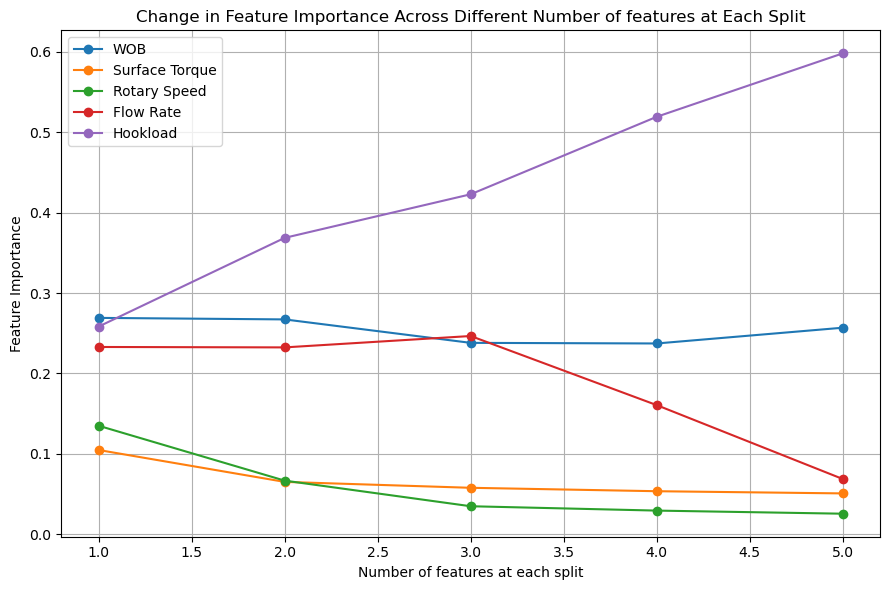

In [42]:
feature_names = x.columns
m = x.shape[1]              
max_features_list = range(m, 0, -1)  # from m down to 1
importance_records = {}

for mf in max_features_list:
    rf = RandomForestRegressor(
        n_estimators=100,
        max_features=mf,
        oob_score=True,
        random_state=42
    )
    rf.fit(x, Y)
    
    importance_records[mf] = rf.feature_importances_      # Record feature importances 
    
feature_importances_by_mf = {name: [] for name in feature_names}
for mf in max_features_list:
    importances = importance_records[mf]
    for i, name in enumerate(feature_names):
        feature_importances_by_mf[name].append(importances[i])

plt.figure(figsize=(9, 6))
for name in feature_names:
    plt.plot(max_features_list, feature_importances_by_mf[name], marker='o', label=name)

plt.xlabel('Number of features at each split')
plt.ylabel('Feature Importance')
plt.title('Change in Feature Importance Across Different Number of features at Each Split')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


###
**Bagging (m = 5)**
- When all features are available at every split, the model tends to rely heavily on whichever feature is most predictive. in our case, it is Hookload. This causes that dominant feature’s importance to skyrocket (around 0.6), overshadowing others that might otherwise contribute.
- Consequently, we can see Hookload occupying the majority of splits, while Rotary Speed, Flow Rate, and WOB remain comparatively underutilized and have lower importance. 
- Relying too much on a single feature could increase variance and reduce generalization if the feature is noisy or unstable. 

**Random Forest with Fewer Features per Split (1 <= max_features < m)**
- Allowing only one or two features at each node forces the model to consider alternative splits when the top feature(s) aren’t always in the running.
- at m = 1, Hookload may be excluded from many splits simply due to the random draw since only one feature allowed, and it won’t always be Hookload. WOB  thus gets the opportunity to appear and become a key decision node, which increases its relative importance while Hookload importance is lower.


Overall, this underscores how Random Forest (with fewer features per split) can spread importance across other predictors, but if a feature is truly dominant and max_features isn’t extremely restrictive, it will typically remain on top.



###  3. Conclusion 

This project demonstrates the trade-off between pure Bagging and more fully randomized splits (Random Forest) when predicting Rate of Penetration (ROP) from drilling data. By systematically varying the number of features (max_features) allowed at each tree split, we observed the following key insights:

**1. OOB MSE vs. max_features:**

- Using all features at each split (i.e., Bagging) often causes one dominant feature (e.g., Hookload) to overshadow others, producing higher tree–tree correlation and potentially suboptimal accuracy.

When fewer features per split are allowed, tree decorrelation increases, and the ensemble’s overall prediction performance can improve, up to a point.

**2. Tree–Tree Correlation:**

- Measuring the average correlation among individual tree predictions confirms that sub-sampling features at each split is a powerful mechanism for increasing diversity (reducing correlation). This diversity is crucial for boosting ensemble accuracy.

**3. Feature Importance:** 

- With Bagging (all features), any strongly predictive variable tends to dominate splits in most trees.
- As max_features decreases, other predictor features (like WOB and Rotary Speed) gain influence. This shifts the importance landscape and can yield better out-of-bag performance by avoiding excessive reliance on a single feature.

Overall, the results illustrate that Random Forest (as a generalization of Bagging) balances randomness in feature selection with predictive strength at splits, leading to a more robust model. Importantly, there is no universal “best” max_features; rather, the optimal choice depends on the specific dataset, often lying between 1 and the total number of features. This underscores the value of experimentally tuning hyperparameters like max_features to maximize model accuracy, decorrelate trees, and gain deeper insights into how each feature contributes to drilling-performance prediction

### Parting Comments

👋 Hey there, My name is Nassima Bettir. I am a PhD Student at Hildebrand Department of Petroleum and Geosystems Engineering and a Graduate Research Assistant at RAPID Research Consortium.

Feel free to reach out or connect with me here:

📧 Email: nbettir@utexas.edu

💼 LinkedIn: https://www.linkedin.com/in/nassimabettir/

🐙 GitHub: https://github.com/nassima314

🔬 Research Interests : 
  - Geothermal Energy
  - Machine Learning
  - Drilling Engineering

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)